In [2]:
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import missingno as msno
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from collections import defaultdict

foodSep = {'HEALTH':pd.DataFrame, 'SOCIOECONOMIC':pd.DataFrame}
for k, n in foodSep.items():
    foodSep[k] = pd.read_csv(k + '.csv')

In [3]:
foodSep['HEALTH'].head()

,FIPS,State,County,PCT_DIABETES_ADULTS08,PCT_DIABETES_ADULTS13,PCT_OBESE_ADULTS08,PCT_OBESE_ADULTS13,PCT_HSPA15,RECFAC09,RECFAC14,PCH_RECFAC_09_14,RECFACPTH09,RECFACPTH14,PCH_RECFACPTH_09_14
0,1001,AL,Autauga,11.4,13.0,31.5,34.1,25.4,4,5,25.000000,0.073889,0.090261,22.156783
1,1003,AL,Baldwin,9.8,10.4,26.2,27.4,25.4,18,25,38.888889,0.100331,0.124931,24.518392
2,1005,AL,Barbour,13.6,18.4,37.6,44.4,25.4,1,0,-100.000000,0.036157,0.000000,-100.000000
3,1007,AL,Bibb,11.1,14.8,32.3,40.3,25.4,1,1,0.000000,0.043590,0.044433,1.932818
4,1009,AL,Blount,11.4,14.1,31.9,34.6,25.4,3,3,0.000000,0.052319,0.051976,-0.654897


In [4]:
#combine all separate categories into one dataframe
# for simplicity. All categories have same number of rows
food = pd.concat(foodSep, axis=1)

In [5]:
#confirm combination
print(foodSep['HEALTH'].shape)
print(food.shape)
#things to investigate:
# sales to farmers
# food insecurity and very low food security
# adult diabetes and obesity rates

(3143, 14)
(3143, 32)


In [6]:
#replace empty rows, which according to doc are empty info
# with proper NaN so we can visualize how much info we're missing
for index, row in food.iterrows():
    for k, i in food.items():
        if food.loc[index, k] == "":
            food.loc[index, k] = NaN

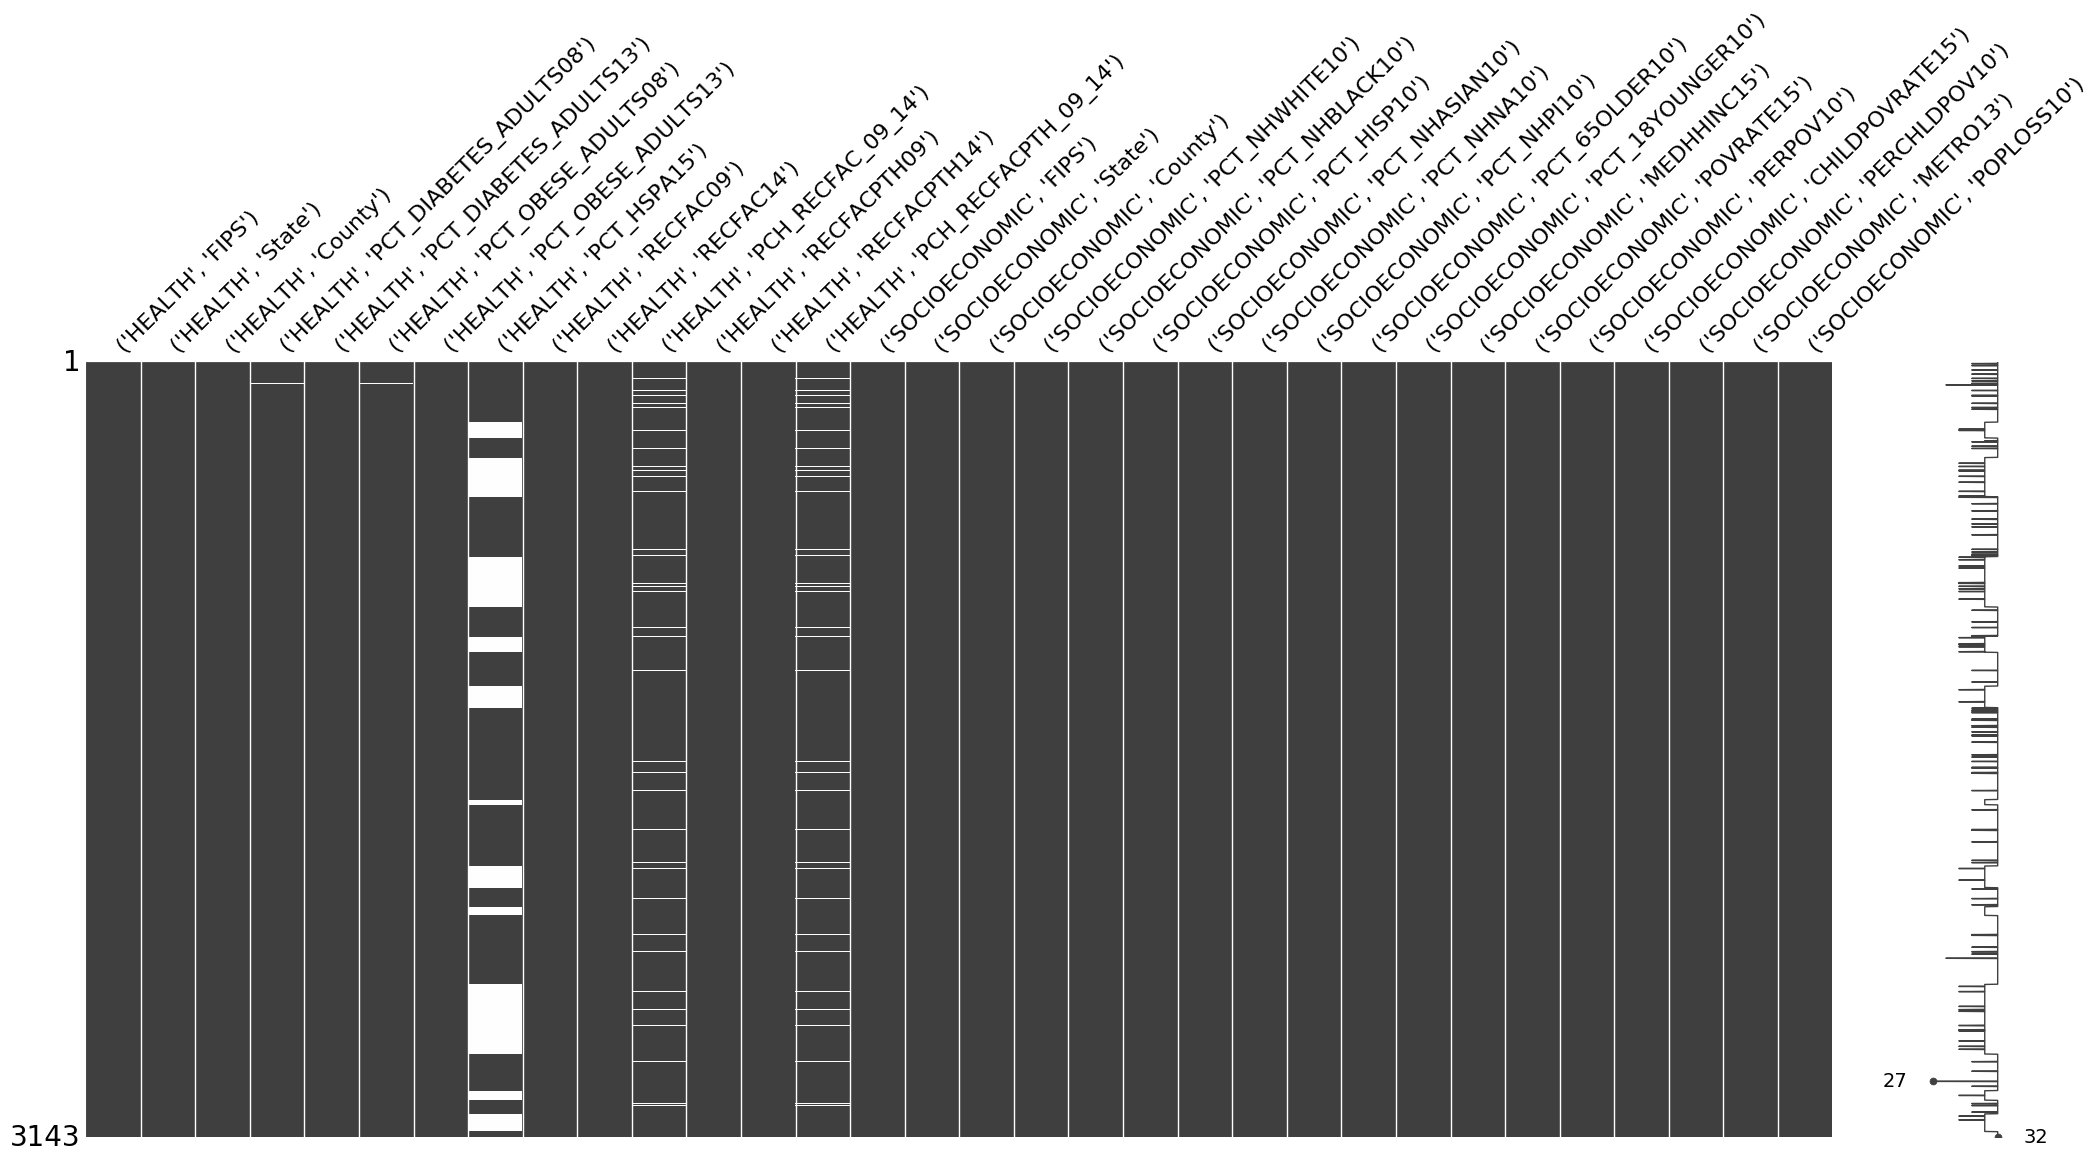

In [7]:
msno.matrix(food)

In [8]:
#Now that we see there's lots of info missing
# in some areas, lets find out which categories
# those areas correspond to
for k, i in food.items():
    print(k, sum(pd.isnull(food[k])))

('HEALTH', 'FIPS') 0
('HEALTH', 'State') 0
('HEALTH', 'County') 0
('HEALTH', 'PCT_DIABETES_ADULTS08') 5
('HEALTH', 'PCT_DIABETES_ADULTS13') 1
('HEALTH', 'PCT_OBESE_ADULTS08') 5
('HEALTH', 'PCT_OBESE_ADULTS13') 1
('HEALTH', 'PCT_HSPA15') 1118
('HEALTH', 'RECFAC09') 0
('HEALTH', 'RECFAC14') 0
('HEALTH', 'PCH_RECFAC_09_14') 123
('HEALTH', 'RECFACPTH09') 0
('HEALTH', 'RECFACPTH14') 0
('HEALTH', 'PCH_RECFACPTH_09_14') 123
('SOCIOECONOMIC', 'FIPS') 0
('SOCIOECONOMIC', 'State') 0
('SOCIOECONOMIC', 'County') 0
('SOCIOECONOMIC', 'PCT_NHWHITE10') 0
('SOCIOECONOMIC', 'PCT_NHBLACK10') 0
('SOCIOECONOMIC', 'PCT_HISP10') 0
('SOCIOECONOMIC', 'PCT_NHASIAN10') 0
('SOCIOECONOMIC', 'PCT_NHNA10') 0
('SOCIOECONOMIC', 'PCT_NHPI10') 0
('SOCIOECONOMIC', 'PCT_65OLDER10') 0
('SOCIOECONOMIC', 'PCT_18YOUNGER10') 0
('SOCIOECONOMIC', 'MEDHHINC15') 4
('SOCIOECONOMIC', 'POVRATE15') 4
('SOCIOECONOMIC', 'PERPOV10') 0
('SOCIOECONOMIC', 'CHILDPOVRATE15') 4
('SOCIOECONOMIC', 'PERCHLDPOV10') 0
('SOCIOECONOMIC', 'METRO13') 0

In [9]:
#Lets remove categories which have too much missing information,
# here we removed all columns with more than 200 missing values
food_clean = food[[x[0] for x in food.items() if sum(pd.isnull(food[x[0]])) < 10]]
food_clean.shape

(3143, 29)

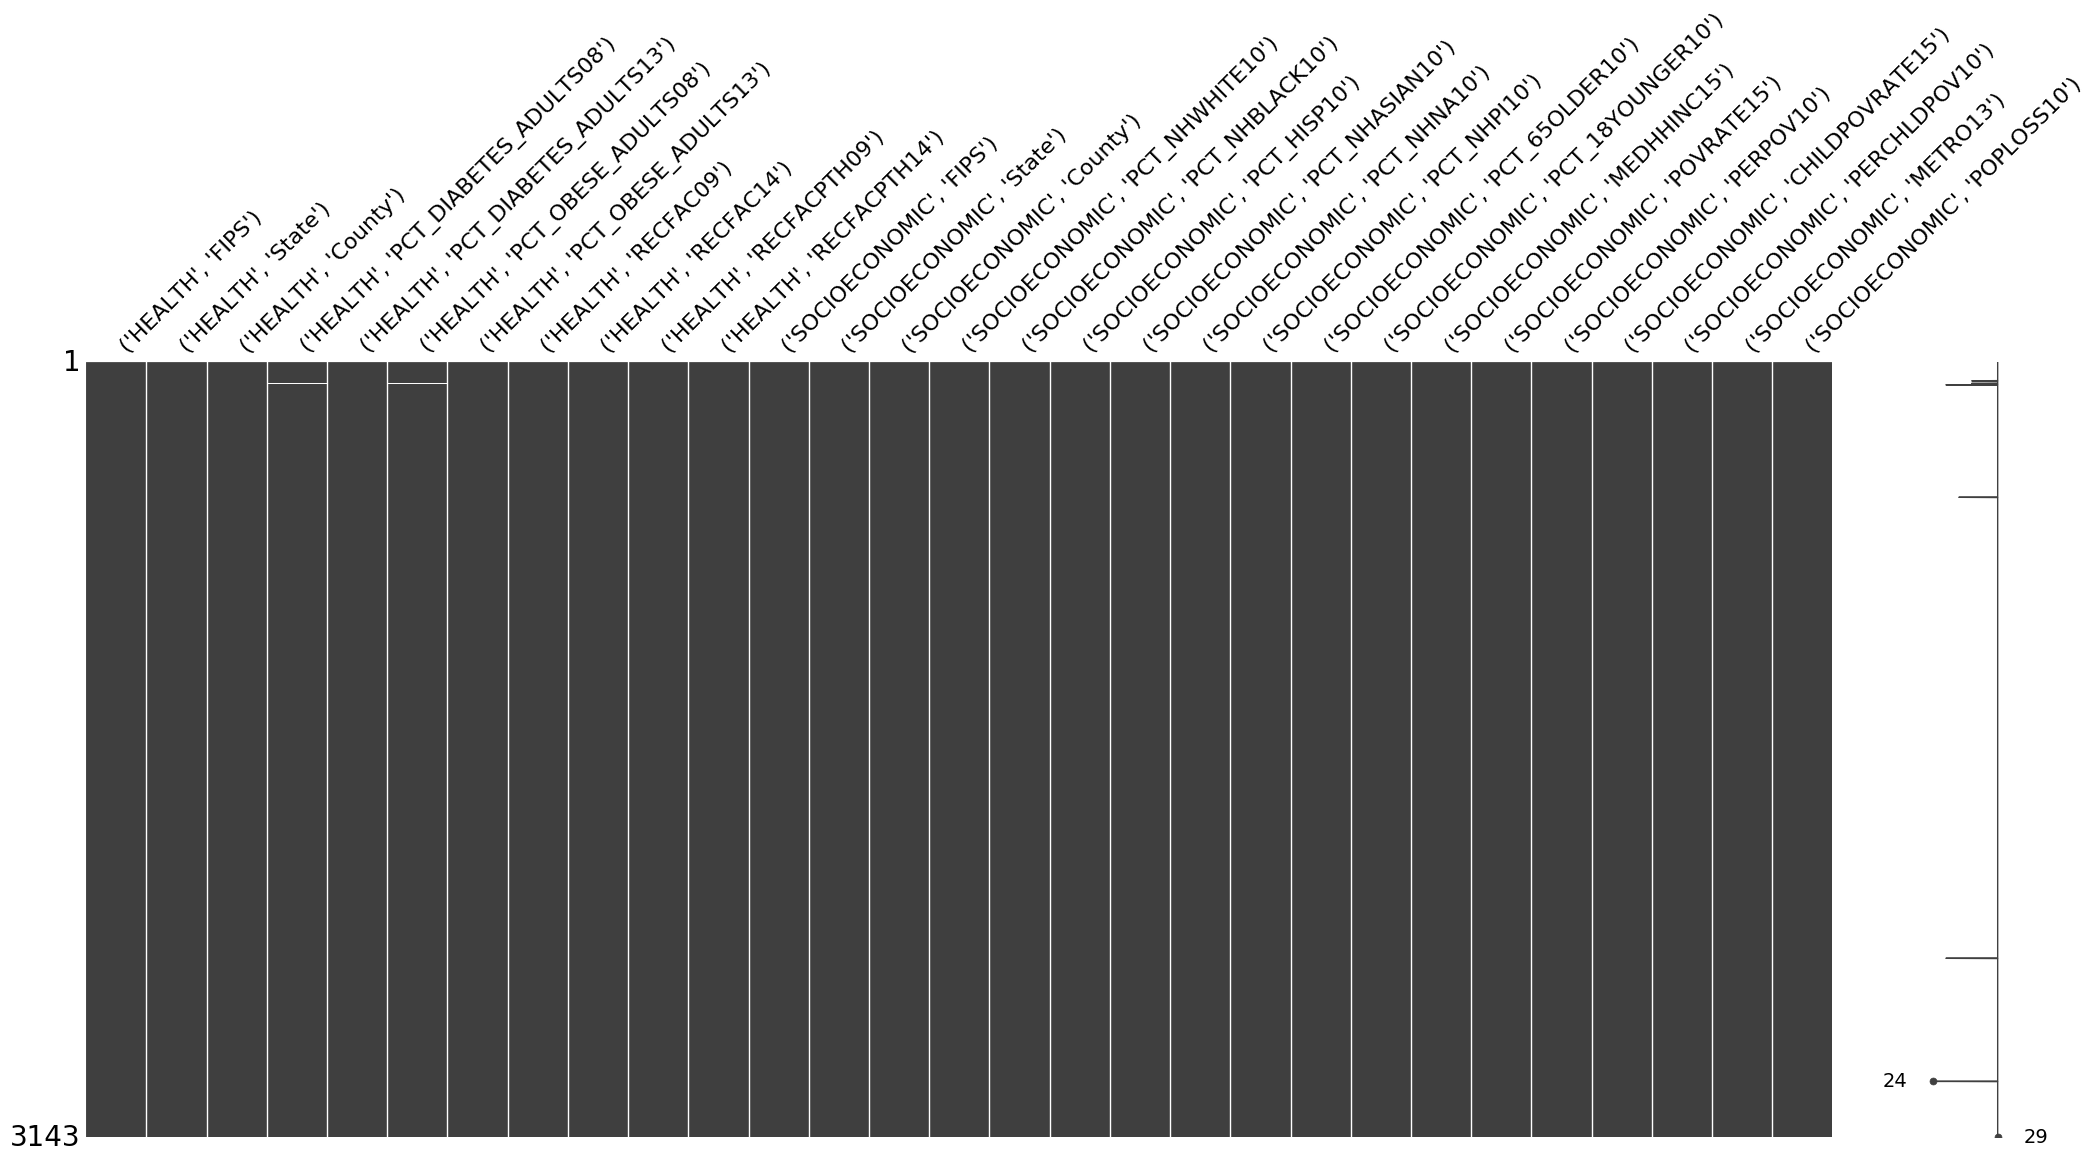

In [10]:
msno.matrix(food_clean)

In [ ]:
# now lets remove rows with missing values
for i, row in food_clean.iterrows():
    if sum(pd.isnull(row)) > 0:
        food_clean = food_clean.drop(i)
print(food_clean.shape)
print(sum(sum(pd.isnull([food_clean[x[0]] for x in food_clean.items()]))))

(3134, 29)
0


In [ ]:
msno.matrix(food_clean)

In [ ]:
#Replace missing values with average for category.
# logic is that since the missing values make up such a
# small part of the dataset (about .2%), it would not 
# skew the results too much, while still retaining a large
# amount of data that would have been lost had we simply removed 
# the entire rows

for index, (k, a) in enumerate(food_clean.items()):
    #skip over first three categories
    if sum(pd.isnull(a)) > 0 and index > 2:
        average = 0
        for ind, (num, val) in enumerate(a.items()):
            #Need to correct key index values because we dropped rows
            # (ex. [0:"foo", 1:'foo', 2:'foo'] >*drop item 1*> [0:'foo', 2:'foo'], <- need to correct)
            if ind != num:
                a[ind] = a.pop(num)
            if not pd.isnull(val):
                average += val # < for some reason this wont work
        average /= (len(a) - sum(pd.isnull(a)))
        for i in range(len(a)):
            if pd.isnull(a[i]):
                food_clean[k][i] = average

In [ ]:
msno.matrix(food_clean)

In [ ]:
#let's grab state, county, percent obesity 2013, percent diabetes 2013, poverty rate 2015
health_df = food_clean['HEALTH'][['FIPS','State','County','PCT_OBESE_ADULTS13','PCT_DIABETES_ADULTS13']]
poverty_df = food_clean['SOCIOECONOMIC'][['FIPS','State','County','POVRATE15']]


health_df.reset_index(drop=True)
poverty_df.reset_index(drop=True)

print('Size of health df:', health_df.shape)
print('Size of poverty df:', poverty_df.shape)

In [ ]:
#combining the two sets of data
df = health_df.copy()

#we want to ensure that the data lines up
for index, row in df.iterrows():
    assert(poverty_df['FIPS'][index] == df['FIPS'][index])

df['POVRATE15'] = poverty_df['POVRATE15']
df.head()

In [ ]:
# Let's get the variables we care about
obesity = df['PCT_OBESE_ADULTS13']
diabetes = df['PCT_DIABETES_ADULTS13']
poverty = df['POVRATE15']

In [ ]:
obesity_array = obesity.as_matrix().reshape(-1,1)
diabetes_array = diabetes.as_matrix().reshape(-1,1)
poverty_array = poverty.as_matrix().reshape(-1,1)

In [ ]:
# Let's take a look at Diabetes vs Poverty
    
regr = LinearRegression()
regr.fit(poverty_array,diabetes_array)
prediction = regr.predict(poverty_array)
    
plt.scatter(poverty_array,diabetes_array)
plt.plot(poverty_array, prediction, c='red')
plt.xlabel('Poverty Rate')
plt.ylabel('Percent Adult Diabetes')
plt.show()

In [ ]:
# Let's take a look at Diabetes vs Poverty
    
regr = LinearRegression()
regr.fit(poverty_array,obesity_array)
prediction = regr.predict(poverty_array)
    
plt.scatter(poverty_array,obesity_array)
plt.plot(poverty_array, prediction, c='red')
plt.xlabel('Poverty Rate')
plt.ylabel('Percent Adult Obesity')
plt.show()